# Quantify well position effect
**Author:** Jessica Ewald <br>

The purpose of this notebook is to analyze the pairwise distances between cells across different well positions. There are 48 wells with ALK-WT and 48 wells with ALK-VAR.

In [1]:
# Imports

import pandas as pd
import polars as pl
import numpy as np
import pathlib
from tqdm import tqdm
import os
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
# Define paths
data_dir = pathlib.Path(f"/dgx1nas1/storage/data/jess/varchamp/sc_data/classification_results/B4A3R1/ALK_WT_VAR/")
file_path = f"{data_dir}/B4A3R1_well_distances.csv"

In [3]:
# Read in data
dists = pl.read_csv(file_path)

In [4]:
# Convert well name into row and column coordinates
dists = dists.with_columns(pl.col("Well_1").str.slice(0,1).alias("Well_1_Letter"),
                           pl.col("Well_1").str.slice(1).cast(pl.Int64).alias("Well_1_Col"),
                           pl.col("Well_2").str.slice(0,1).alias("Well_2_Letter"),
                           pl.col("Well_2").str.slice(1).cast(pl.Int64).alias("Well_2_Col"))

letter_dict = {"A":1, "B":2, "C":3, "D":4, "E":5, "F":6, "G":7, "H":8, "I":9, "J":10, "K":11, "L":12, "M":13, "N":14, "O":15, "P":16}

dists = dists.with_columns(pl.Series(name="Well_1_Row", values=[letter_dict[val] for val in dists.select(pl.col("Well_1_Letter")).to_series()]),
                           pl.Series(name="Well_2_Row", values=[letter_dict[val] for val in dists.select(pl.col("Well_2_Letter")).to_series()]))


In [5]:
# Compute physical distance between pairs of wells
import math

phys_dist = []
for row in dists.rows(named=True):
    phys_dist.append(math.dist([row['Well_1_Row'], row['Well_1_Col']], [row['Well_2_Row'], row['Well_2_Col']]))
    
same_allele = dists['Allele_1'].eq(dists['Allele_2']).cast(pl.String).to_list()

In [6]:
dists = dists.with_columns(pl.Series(name="Phys_dist", values=phys_dist),
                           pl.Series(name="Same_allele", values=same_allele))

In [86]:
# Compute correlation between cosine similarity and physical distance for each well

dist_cor = dists.group_by("Well_1").agg(pl.corr("cosine_dist_mean", "Phys_dist").alias("Cor_Physdist_Cosdist"),
                                        pl.corr("euclid_dist_mean", "Phys_dist").alias("Cor_Physdist_Eucdist"))

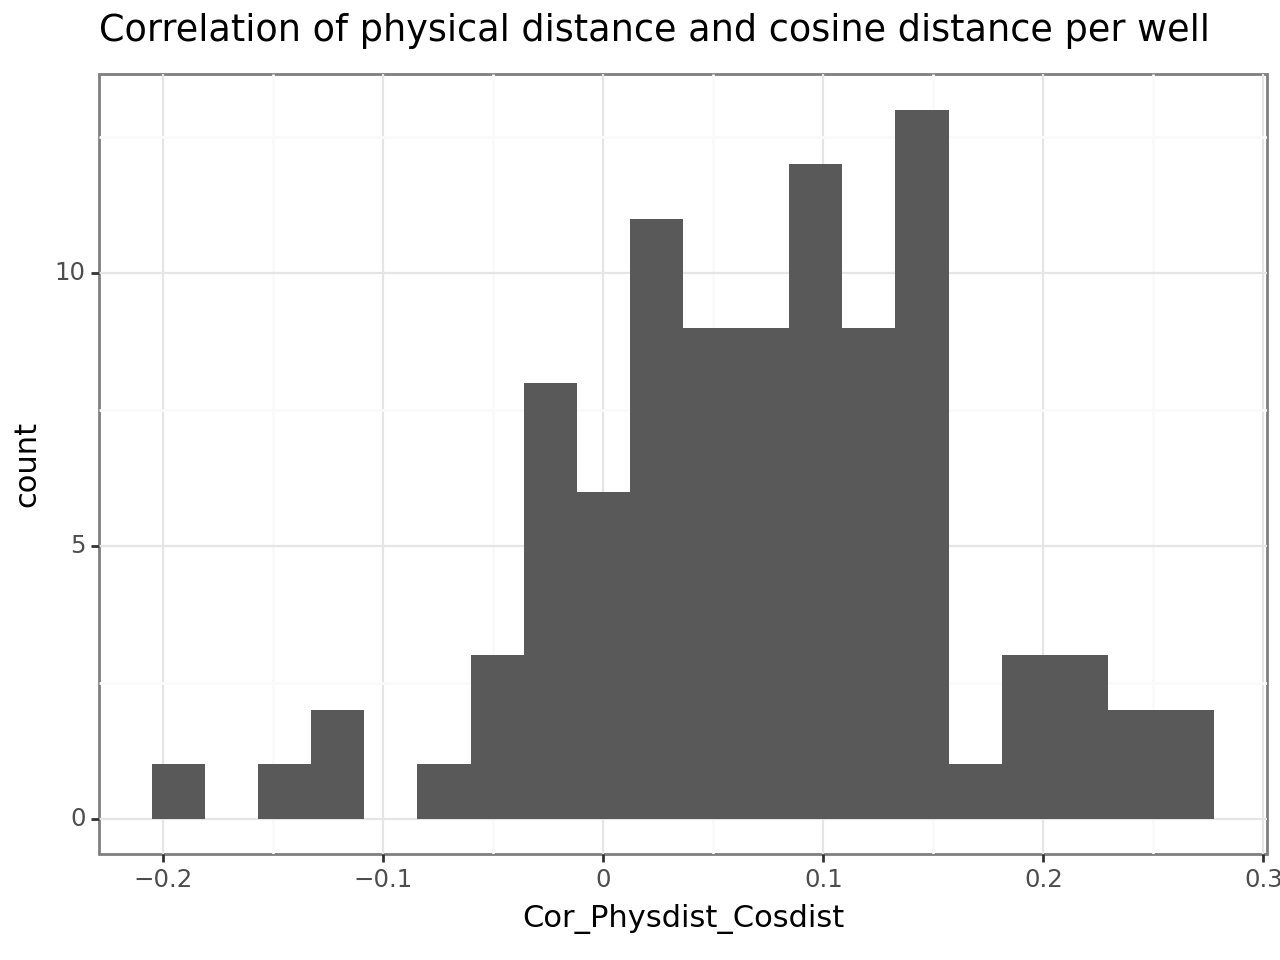

<Figure Size: (640 x 480)>

In [87]:
from plotnine import ggplot, aes, geom_histogram, theme_bw, ggtitle

plot1 = (ggplot(dist_cor)
         + aes(x = "Cor_Physdist_Cosdist")
         + geom_histogram(bins = 20) + theme_bw() + ggtitle("Correlation of physical distance and cosine distance per well"))
plot1

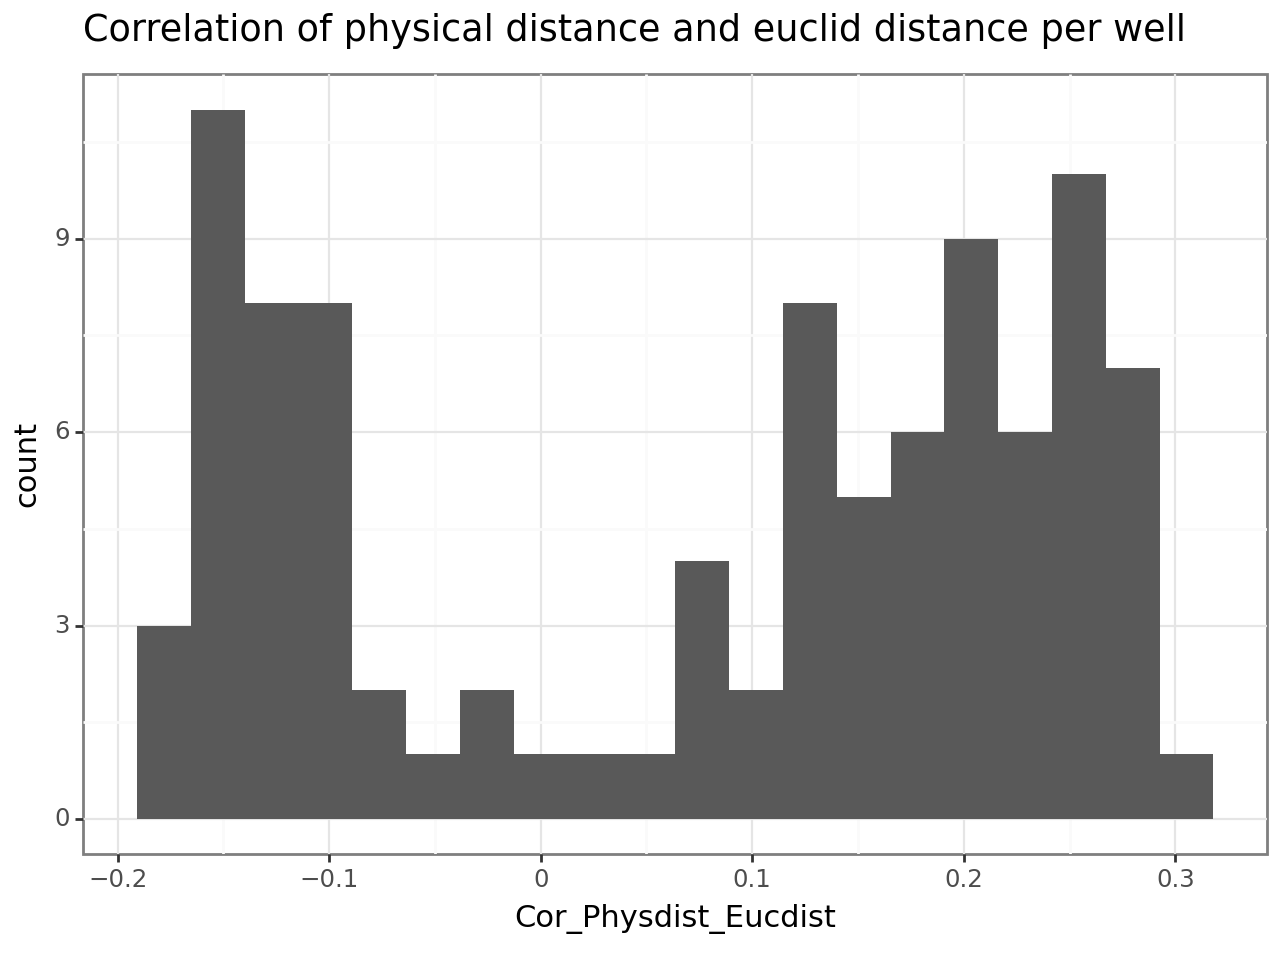

<Figure Size: (640 x 480)>

In [88]:
plot2 = (ggplot(dist_cor)
         + aes(x = "Cor_Physdist_Eucdist")
         + geom_histogram(bins = 20) + theme_bw() + ggtitle("Correlation of physical distance and euclid distance per well"))
plot2

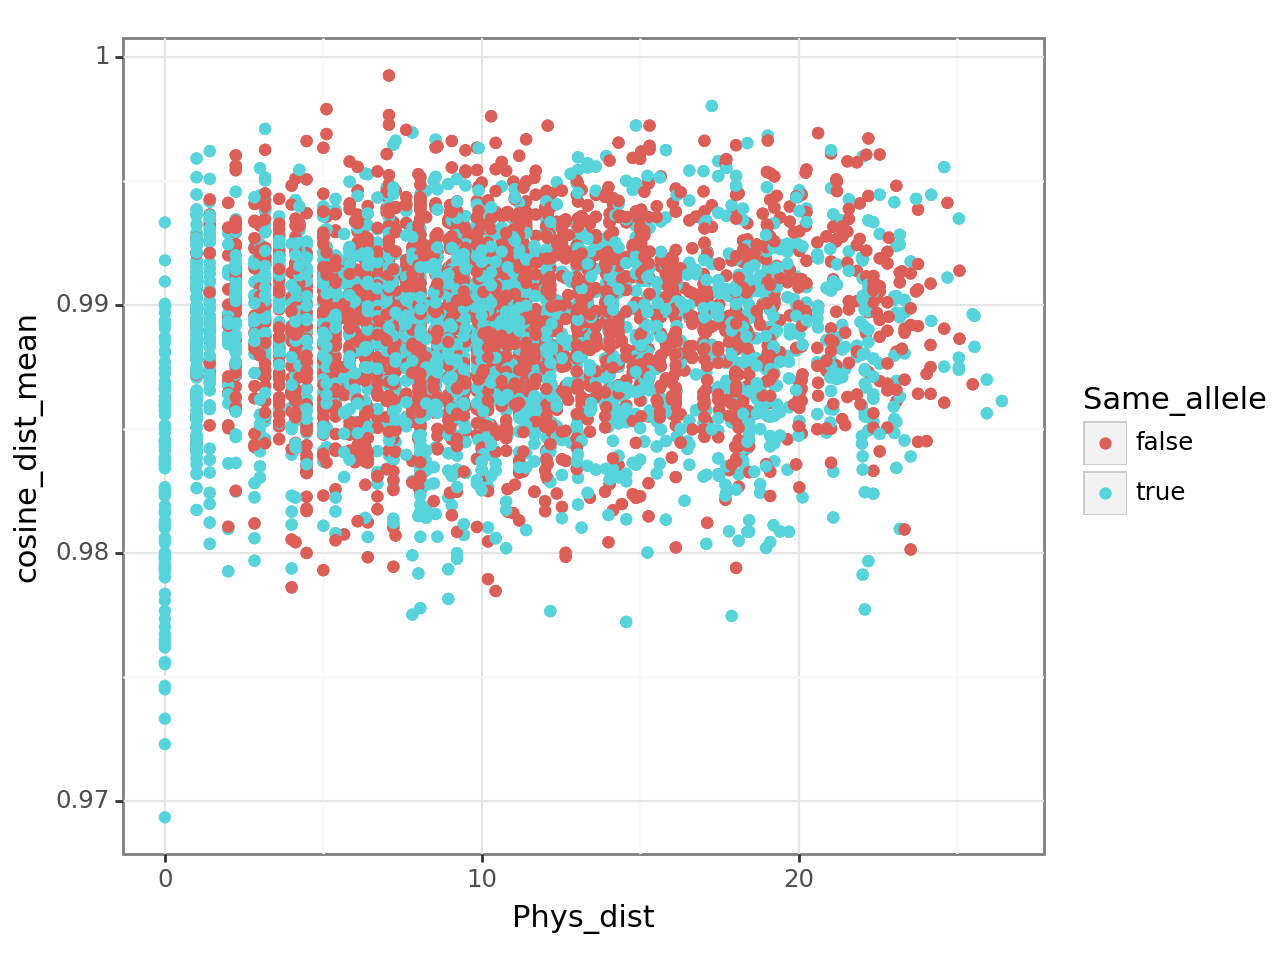

<Figure Size: (640 x 480)>

In [89]:
from plotnine import ggplot, aes, geom_point, theme_bw

plot1 = (ggplot(dists)
         + aes(x = "Phys_dist", y = "cosine_dist_mean", color = "Same_allele")
         + geom_point() + theme_bw())
plot1

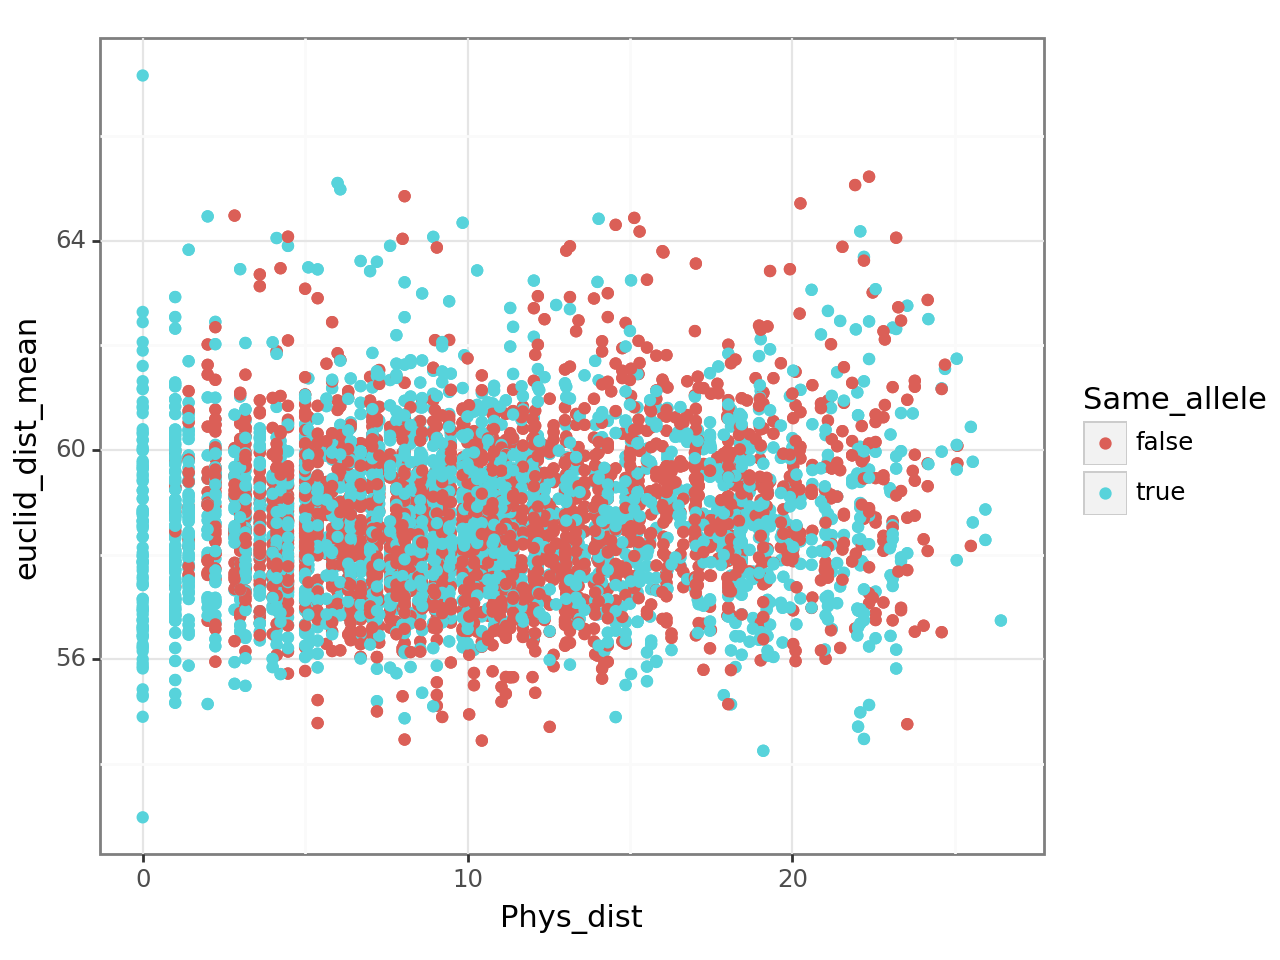

<Figure Size: (640 x 480)>

In [90]:
from plotnine import ggplot, aes, geom_point, theme_bw

plot1 = (ggplot(dists)
         + aes(x = "Phys_dist", y = "euclid_dist_mean", color = "Same_allele")
         + geom_point() + theme_bw())
plot1

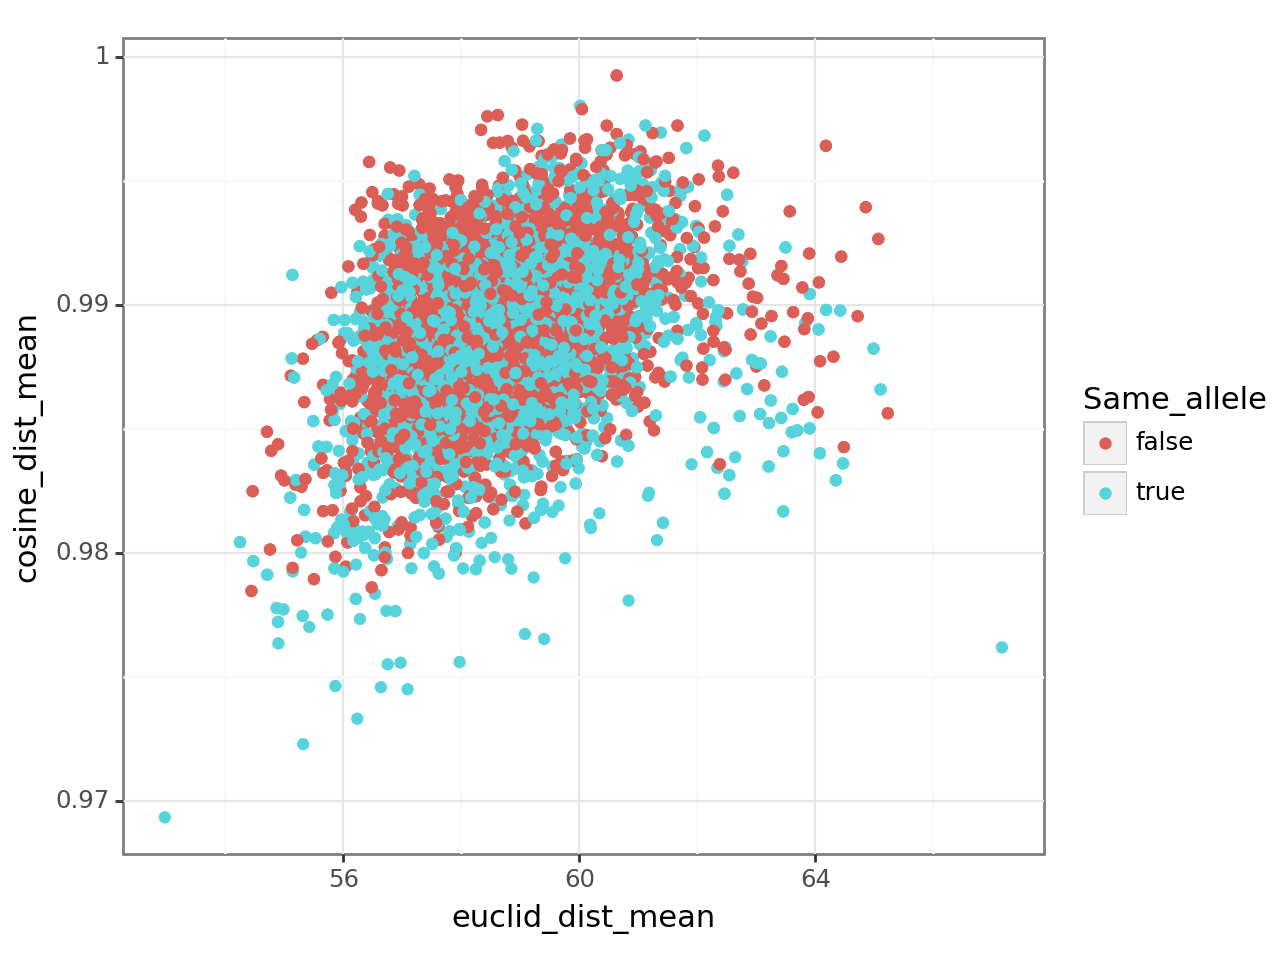

<Figure Size: (640 x 480)>

In [91]:
from plotnine import ggplot, aes, geom_point, theme_bw

plot1 = (ggplot(dists)
         + aes(x = "euclid_dist_mean", y = "cosine_dist_mean", color = "Same_allele")
         + geom_point() + theme_bw())
plot1

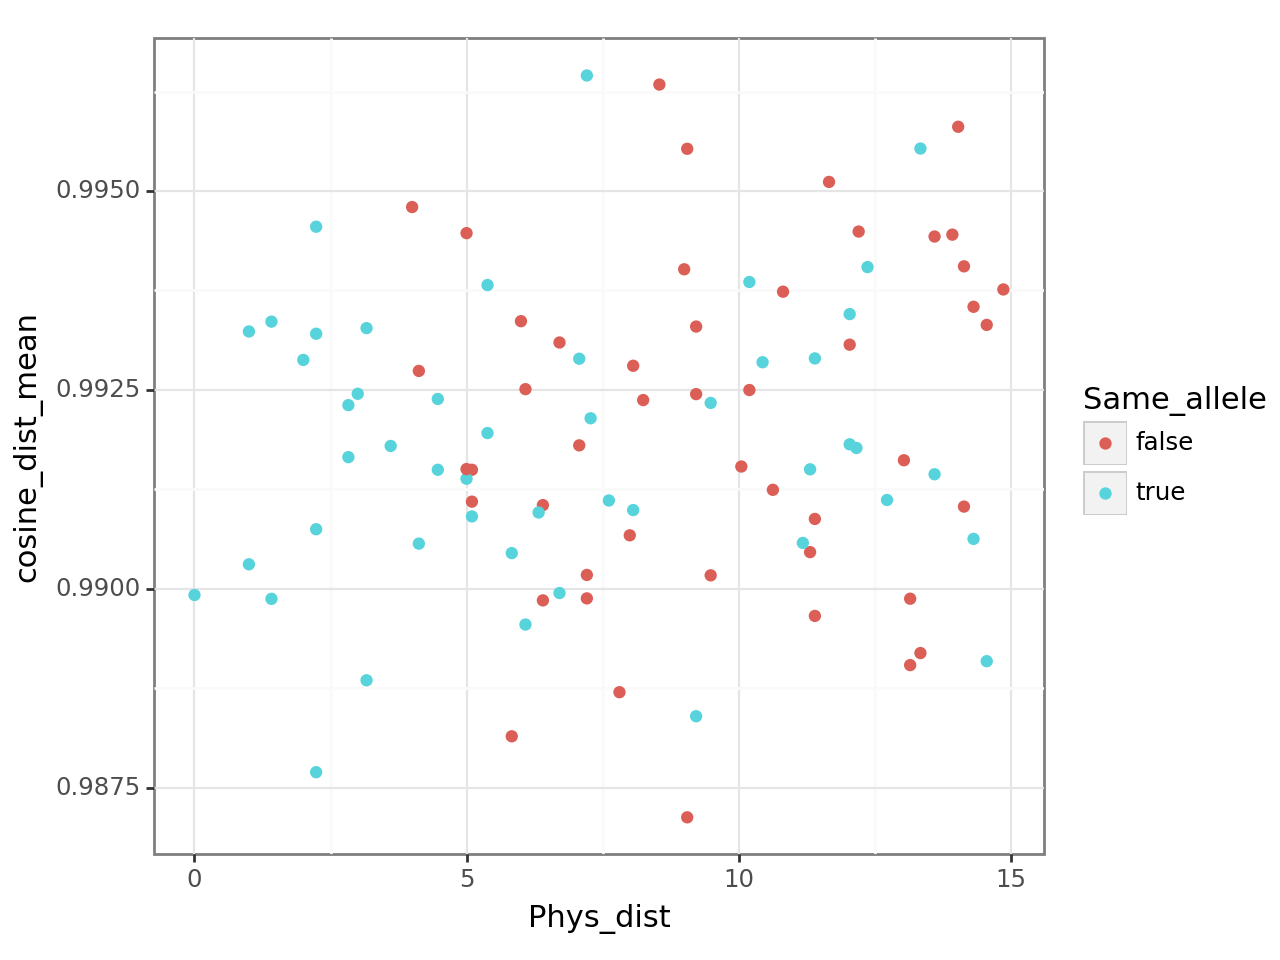

<Figure Size: (640 x 480)>

In [92]:
# Well with highest correlation between physical distance and cosine distance
well_ID = "G15"
dist_well = dists.filter(pl.col("Well_1") == well_ID)


from plotnine import ggplot, aes, geom_point, theme_bw

plot1 = (ggplot(dist_well)
         + aes(x = "Phys_dist", y = "cosine_dist_mean", color = "Same_allele")
         + geom_point() + theme_bw())
plot1

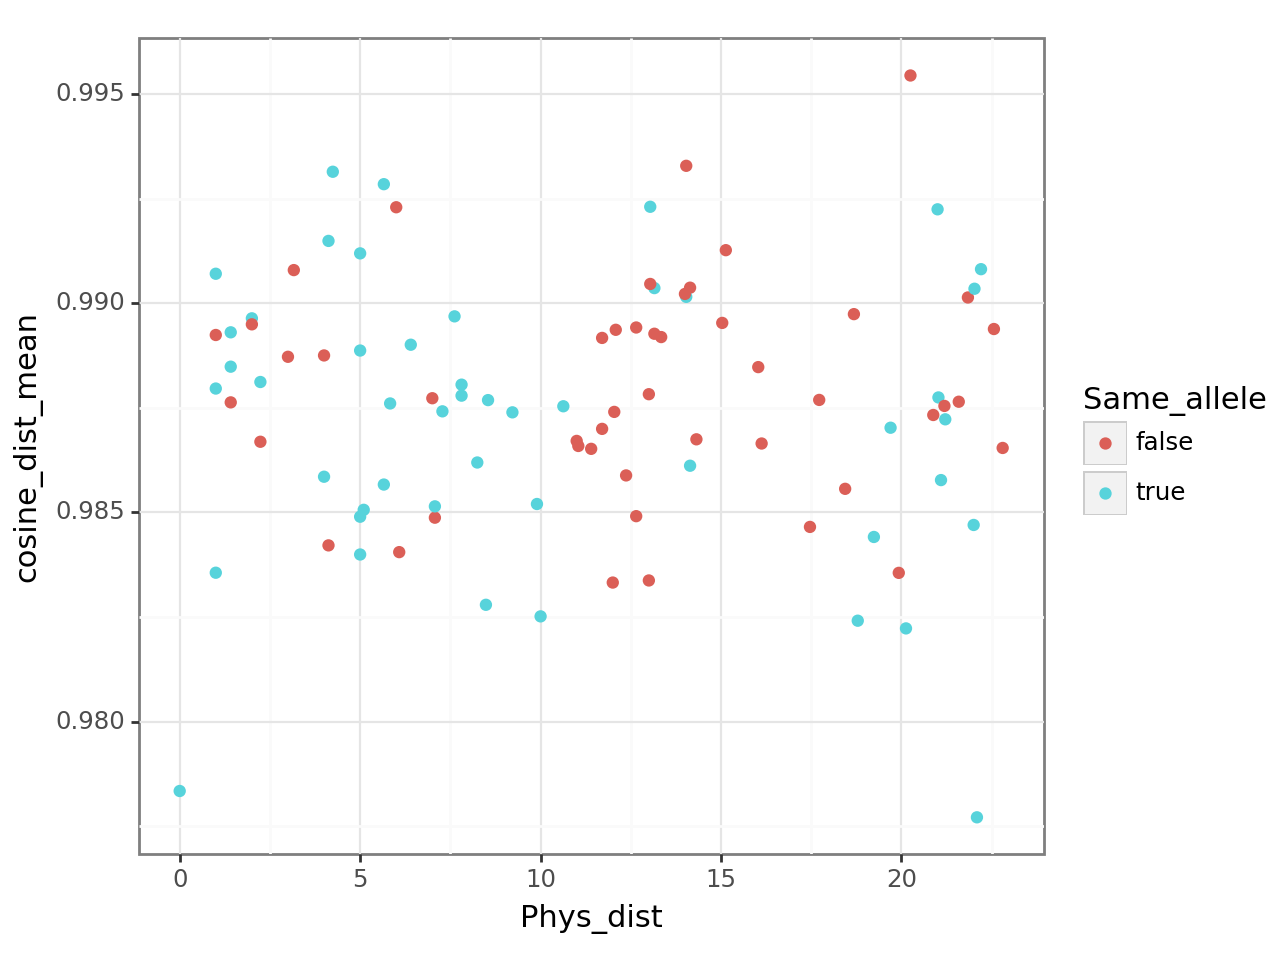

<Figure Size: (640 x 480)>

In [93]:
# Well with lowest correlation between physical distance and cosine distance
well_ID = "J02"
dist_well = dists.filter(pl.col("Well_1") == well_ID)


from plotnine import ggplot, aes, geom_point, theme_bw

plot1 = (ggplot(dist_well)
         + aes(x = "Phys_dist", y = "cosine_dist_mean", color = "Same_allele")
         + geom_point() + theme_bw())
plot1

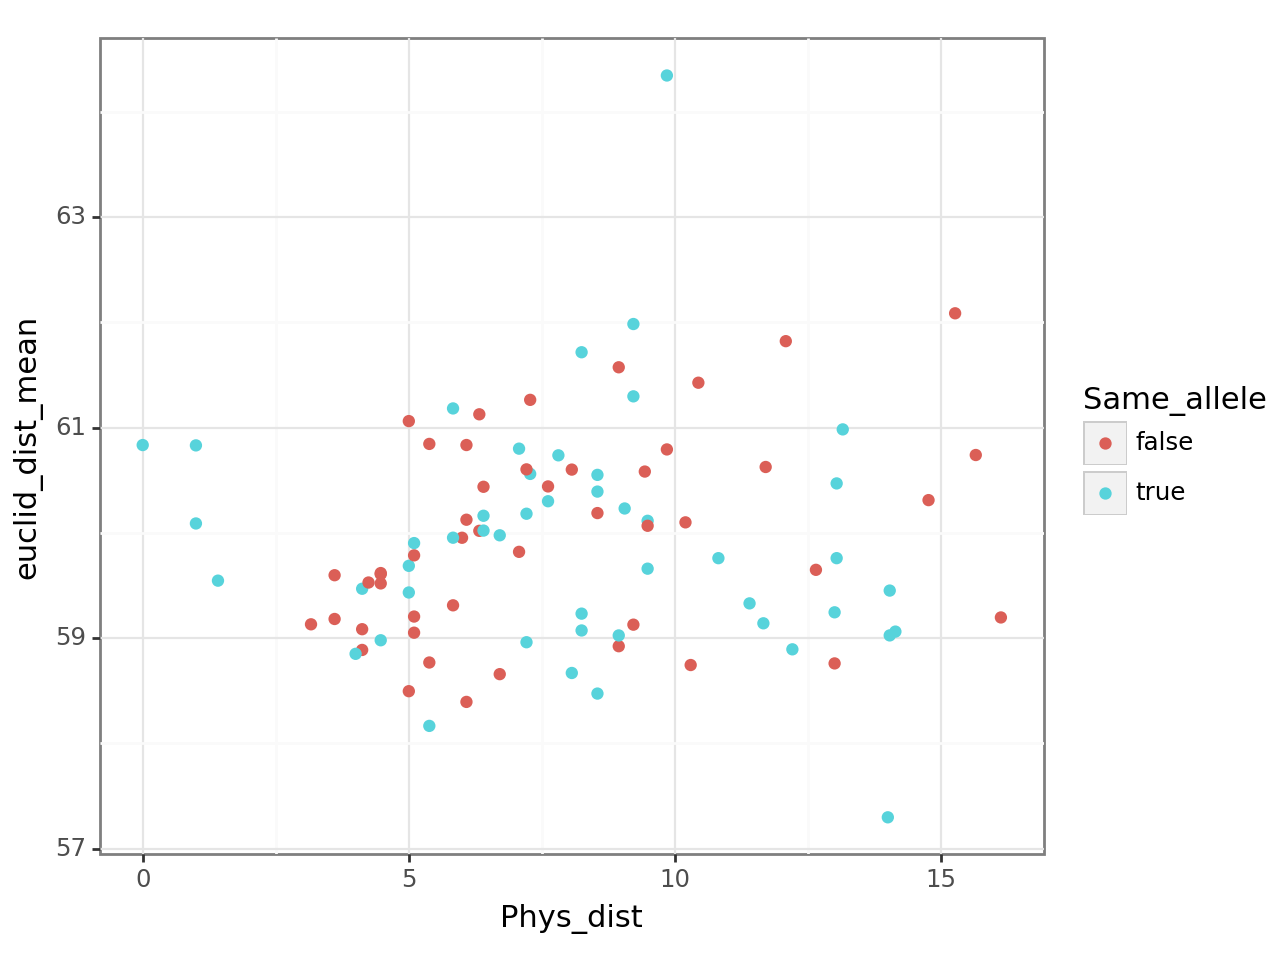

<Figure Size: (640 x 480)>

In [94]:
# highest correlation between physical and euclidean distance 

well_ID = "H10"
dist_well = dists.filter(pl.col("Well_1") == well_ID)


from plotnine import ggplot, aes, geom_point, theme_bw

plot1 = (ggplot(dist_well)
         + aes(x = "Phys_dist", y = "euclid_dist_mean", color = "Same_allele")
         + geom_point() + theme_bw())
plot1

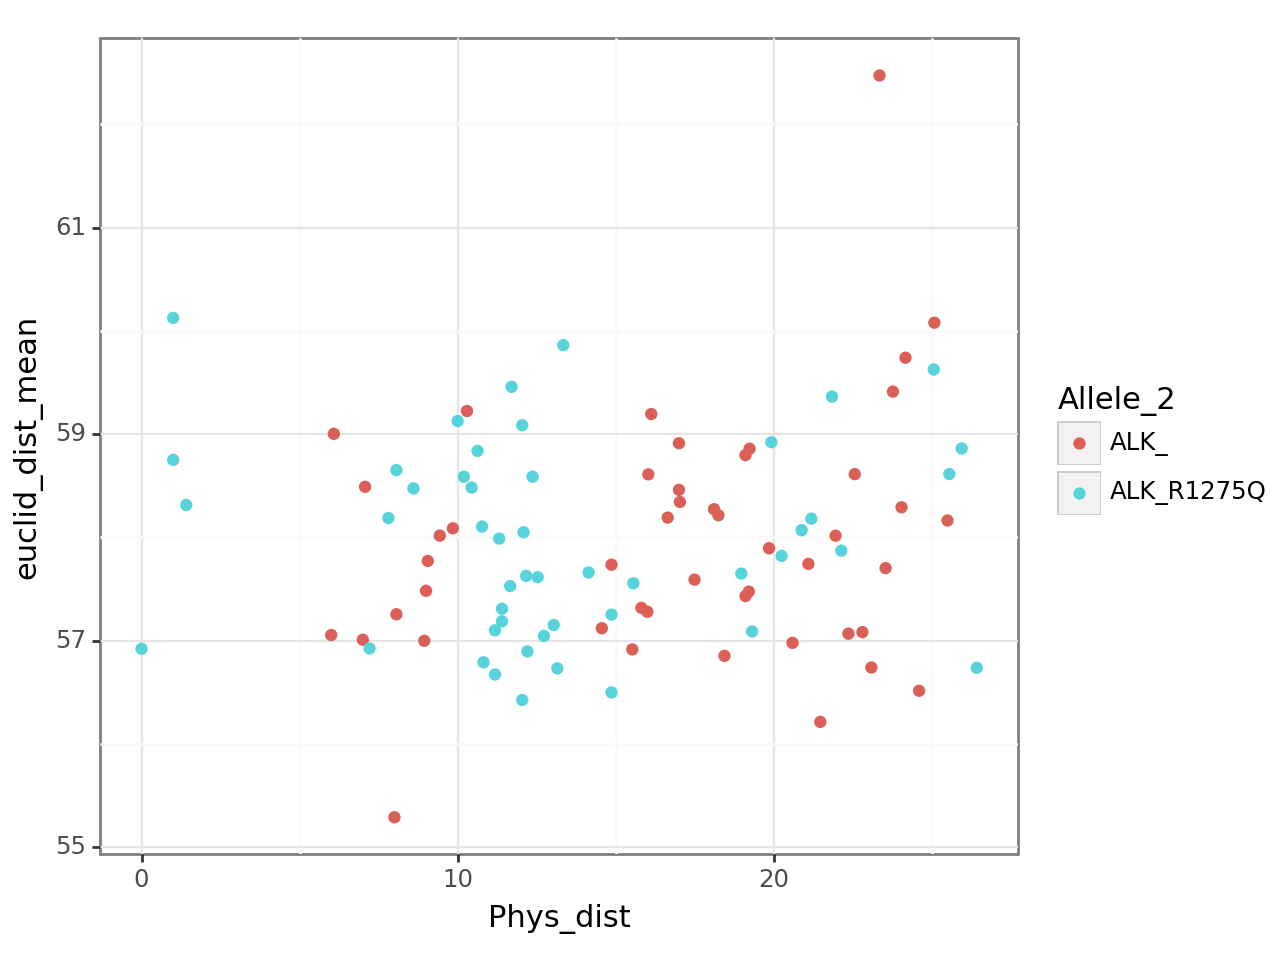

<Figure Size: (640 x 480)>

In [95]:
# lowest correlation between physical and euclidean distance 

well_ID = "P24"
dist_well = dists.filter(pl.col("Well_1") == well_ID)


from plotnine import ggplot, aes, geom_point, theme_bw

plot1 = (ggplot(dist_well)
         + aes(x = "Phys_dist", y = "euclid_dist_mean", color = "Allele_2")
         + geom_point() + theme_bw())
plot1

A perplexing situation: when we build pairwise classifiers between wells, we can always almost perfectly classify cells into their source well. Therefore, this method is "saturated" and doesn't allow us to see how the well position effect increases/decreases across the plate. 

The next step was to try and directly measure the distance between cells in different wells - both Euclidean and cosine. 

These results show that the mean cosine distance and the mean euclidean distance between pairs of cells from two wells have moderate to no correlation with the physical distance between those two wells. There was higher correlation for cosine distance than for euclidean distance. In no cases was it clear that the profile-based distances were systematically smaller for well pairs with the same variant (concerning). 

Basically: appears to be weak well position effects (good) but also no variant effects (bad). 

Perhaps things will be more clear if we only look at the protein channel features because this specific variant was selected as a protein positive control.